# Point Spread Function Analysis

In this section, we will show how to use point spread function analysis and the MRI signal equation along to understand the effects of phenomena such as relaxation and off-resonance/chemical shift on the resulting images, including resulting artifacts created.

## Learning Goals

1. Describe how images are formed
    * What is the impact of relaxation and off-resonance/chemical shift on the signal
1. Understand the constraints and tradeoffs in MRI
    * How do relaxation and off-resonance/chemical shift limit the readout duration
1. Manipulate MRI sequence parameters to improve performance
    * How does the readout duration affect artifacts due to relaxation and off-resonnace/chemical shift
1. Identify artifacts and how to mitigate them
    * What is the effect of relaxation and off-resonnace/chemical shift during the readout on the resulting images

## MRI Signal Equation

To assess the effects of imperfections on resulting images, we start with a comprehensive version of the MRI signal equation, including relaxation, coil sensitivity, off-resonance and chemical shift, and gradients.
The signal from an individual RF coil element $n$ is

$$s_n(t) = \int m(\vec{r})\ C_n(\vec{r})\ e^{-t/T_2^*(\vec{r})}\ e^{-i 2 \pi \Delta f_{cs} t} e^{-i 2 \pi \Delta f_r(\vec{r}) t} \  \exp\left( -i \gamma \int_0^t \vec{G}(\tau) \cdot \vec{r} \ d\tau \right) \  d\vec{r}$$

which is typically simplified for understanding image formation using k-space:

$$s_n(t) = \int m(\vec{r})\ C_n(\vec{r})\ e^{-t/T_2^*(\vec{r})}\ e^{-i 2 \pi \Delta f_{cs} t} e^{-i 2 \pi \Delta f_r(\vec{r}) t} \  e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r}$$

Note that this describes the signal behavior between RF pulses.  Incorporating RF pulses can be done either through rotation matrices or some solution of the Bloch equation such as numerical solvers or phase graphs. 

## K-space Data Weighting

A powerful framework for characterizing the effects of imperfections is to define a k-space weighting that determines the signal modulation.  Expressing this generally, we define a weighting function
$W(\vec{k})$ that can be complex-valued and capture amplitude and phase modulations.  Then, 

$$\hat{M}(\vec{k}) = M(\vec{k}) W(\vec{k}) $$

$$\hat{m}(\vec{r}) = m(\vec{r}) * \mathcal{F}^{-1} \{ W(\vec{k}) \} = m(\vec{r}) * w(\vec{r})$$

Where $w(\vec{r})$ is the inverse Fourier Transform of the weighting function and $*$ is the convolution operation.  $w(\vec{r})$ is also known as a point spread function (PSF) or impulse response function.  Thus the effects can be boiled down to a convolution operation in the resulting reconstructed image.

When the frequency shift and relaxation rates vary across space, it is helpful to decompose the image into components, $m_i$ that experience the same weighting (e.g. same frequency shift, or same $T_2^*$) $W_i$.  

$$ m(\vec{r}) = \sum_i m_i(\vec{r}) $$

Since the Fourier Transform is linear, 

$$\hat{M}(\vec{k}) = \sum_i M_i(\vec{k}) W_i(\vec{k}) $$

$$\hat{m}(\vec{r}) =\sum_i m_i(\vec{r}) * w_i(\vec{r})$$

So each component is convolved with its own convolution kernel.  For example, to analyze chemical shift we can divide our image up into water, $m_1(\vec{r})$, and fat, $m_2(\vec{r})$, components, then $W_1(\vec{k}) = 1$, $W_2(\vec{k}) = e^{-i 2 \pi\ \upsilon(\vec{k}) \Delta f_{fat}}$, and the resulting image will be

$$\hat{m}(\vec{r}) = m_1(\vec{r}) + m_2(\vec{r}) * w_2(\vec{r})$$

providing an accurate image of the water component but some corrupted fat image (typically shifted in space for Cartesian trajectories).


The k-space data weighting concept is very powerful.  It can include frequency shifts. It can include weighting from all types of relaxation ($T_1, T_2, T_2^*$) from more complex acquisition strategies such as SSFP and fast spin-echos.  It can include diffusion-weighting, flow effects, and more.

## Relaxation during signal acquisition

To examine the effects of relaxation, we will neglect coil sensitivity, off-resonance, and chemical shift.  Relaxation modulates the receieved signal over time.  This will create some type of weighting in k-space, which leads to image filtering (often blurring).  This weighting is spatially varying, depending on relaxation of different tissues.

<!-- $$s(t) = \int m(\vec{r}) \ e^{-t/T_2^*(\vec{r})}\  \exp\left( -i \gamma \int_0^t \vec{G}(\tau) \cdot \vec{r} d\tau \right) \  d\vec{r}$$ -->

$$s(t) = \int m(\vec{r})\ e^{-t/T_2^*(\vec{r})}\  e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r}$$

To interpret the effect of relaxation, consider a single value of $T_2^*(\vec{r}) = T_2^*$, in which case this can be removed from the integral and 

$$s(t) = e^{-t/T_2^*} \int m(\vec{r})\ e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r} \\
 = M(\vec{k}(t))\  e^{-t/T_2^*} $$

From this, we can see that relaxation leads to signal amplitude modulation as we acquire data across k-space.  To see the effect on image formation, we determine the function $\upsilon (\vec{k})$ which captures across k-space trajectory in time and across all TRs to characterize this modulation:

$$\hat{M}(\vec{k}) = M(\vec{k}) e^{- \upsilon(\vec{k}) / T_2^*}$$

Examples of $\upsilon(\vec{k})$ are shown below.  In the PSF framework, the k-space weighting function is

$$W(\vec{k}) = e^{- \upsilon(\vec{k}) / T_2^*}$$

Thus the reconstructed image will corrupted by a convolution (denoted by $*$) based on the k-space amplitude weighting

$$\hat{m}(\vec{r}) = \mathcal{F}^{-1} \{ \hat{M}(\vec{k})\} = m(\vec{r}) * \mathcal{F}^{-1} \{ e^{-\upsilon(\vec{k})/  T_2^*} \}$$

And in the framework introduced above, 

$$w(\vec{r}) = \mathcal{F}^{-1} \{ e^{-\upsilon(\vec{k})/  T_2^*} \}$$

This convolution can result in blurring (low-pass filtering) for center-out type trajectories, or high-pass filtering (e.g. edge enhancement but overall SNR loss) when starting at the edge of k-space.

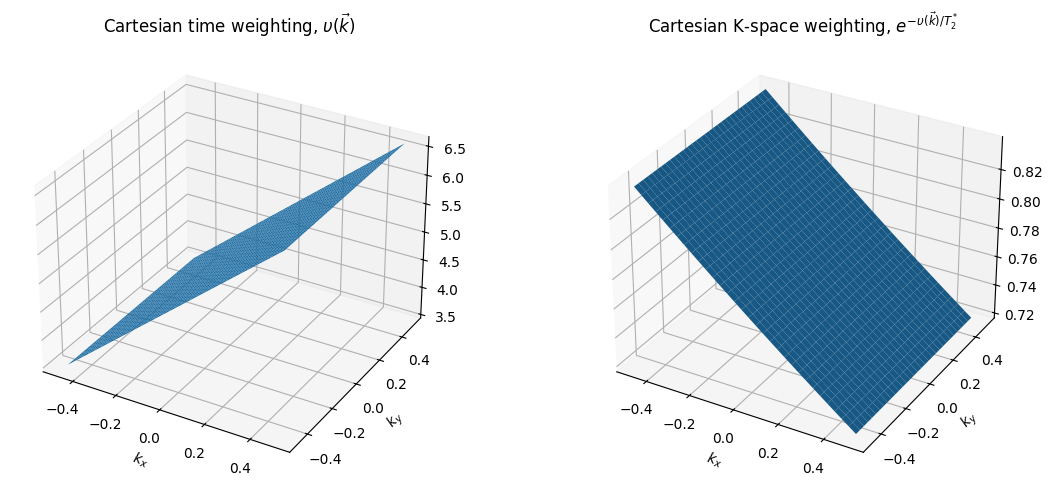

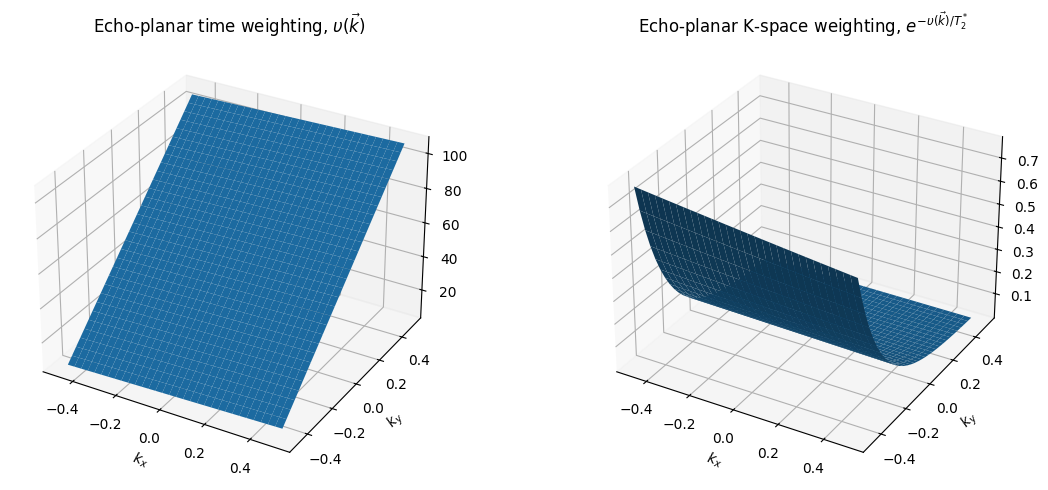

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Example of k-space trajectory time weighting functions, upsilon, and resulting k-space weighting
T2star = 20 # ms

# Cartesian
gamma = 42.58  # kHz/mT
N = 32
dt = 0.1  # ms
TE = 5  # ms
t = np.arange(-N/2+1, N/2+1) * dt

Gxr = 1 / (N * dt * gamma)

kx0 = gamma * Gxr * t
kx, ky = np.meshgrid(kx0, kx0)

upsilon_Cartesian = kx / (gamma * Gxr) + TE

fig = plt.figure(figsize=(12, 5))

# First subplot: Cartesian time weighting
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(kx, ky, upsilon_Cartesian)
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
ax1.set_title(r'Cartesian time weighting, $\upsilon(\vec{k})$')

# Second subplot: Cartesian K-space weighting
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(kx, ky, np.exp(-upsilon_Cartesian / T2star))
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
ax2.set_title(r'Cartesian K-space weighting, $e^{-\upsilon(\vec{k})/  T_2^*}$')

plt.tight_layout()
plt.show()


# EPI
tesp = N * dt  # simplified, assuming no deadtime between ky lines
TE_epi = 5 + tesp * N / 2
tall = np.arange(-N**2/2+1, N**2/2+1) * dt + TE_epi

upsilon_EPI = np.reshape(tall, (N, N))

fig = plt.figure(figsize=(12, 5))

# First subplot: Echo-planar time weighting
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(kx, ky, upsilon_EPI)
ax1.set_xlabel('$k_x$')
ax1.set_ylabel('$k_y$')
ax1.set_title(r'Echo-planar time weighting, $\upsilon(\vec{k})$')

# Second subplot: Echo-planar K-space weighting
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(kx, ky, np.exp(-upsilon_EPI / T2star))
ax2.set_xlabel('$k_x$')
ax2.set_ylabel('$k_y$')
ax2.set_title(r'Echo-planar K-space weighting, $e^{-\upsilon(\vec{k})/  T_2^*}$')

plt.tight_layout()
plt.show()



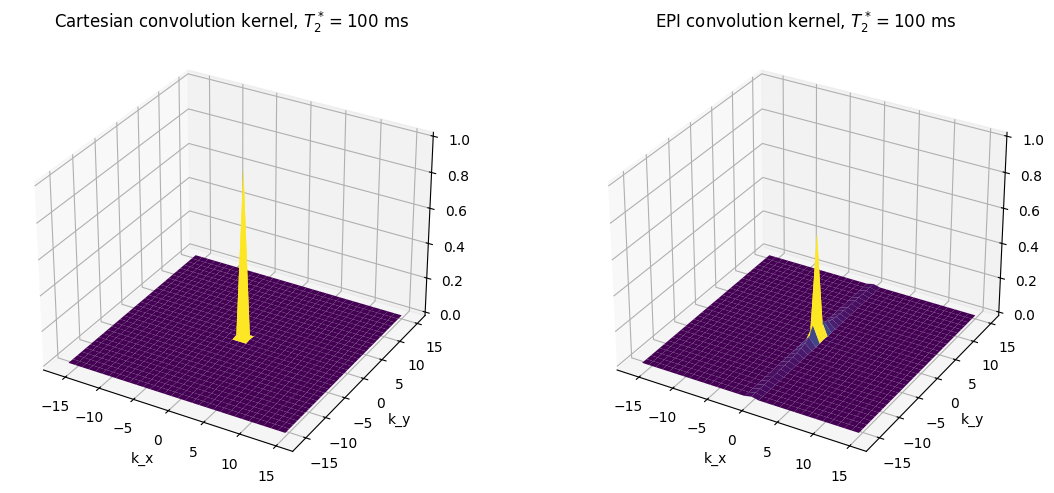

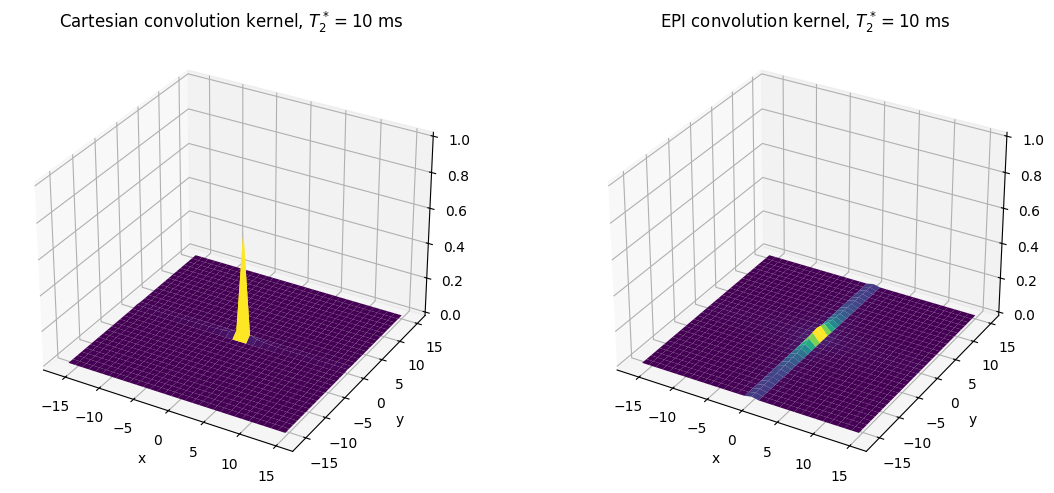

In [18]:
import numpy as np

import matplotlib.pyplot as plt

def ifft2c(x):
    # Centered 2D inverse FFT
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(x)))

# Convolution kernels for T2* weighting

T2star = 100  # ms

W_Cartesian = ifft2c(np.exp(-upsilon_Cartesian / T2star))
W_EPI = ifft2c(np.exp(-upsilon_EPI / T2star))

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(x, y, np.abs(W_Cartesian), cmap='viridis')
ax1.set_xlabel('k_x')
ax1.set_ylabel('k_y')
ax1.set_title(r'Cartesian convolution kernel, $T_2^* = {}$ ms'.format(T2star))
ax1.set_zlim(0, 1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(x, y, np.abs(W_EPI), cmap='viridis')
ax2.set_xlabel('k_x')
ax2.set_ylabel('k_y')
ax2.set_title(r'EPI convolution kernel, $T_2^* = {}$ ms'.format(T2star))
ax2.set_zlim(0, 1)

plt.tight_layout()
plt.show()

T2star = 10  # ms

W_Cartesian = ifft2c(np.exp(-upsilon_Cartesian / T2star))
W_EPI = ifft2c(np.exp(-upsilon_EPI / T2star))

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(x, y, np.abs(W_Cartesian), cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(r'Cartesian convolution kernel, $T_2^* = {}$ ms'.format(T2star))
ax1.set_zlim(0, 1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(x, y, np.abs(W_EPI), cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title(r'EPI convolution kernel, $T_2^* = {}$ ms'.format(T2star))
ax2.set_zlim(0, 1)

plt.tight_layout()
plt.show()

In the above plots, the height of the main peak in the center represents the expected SNR, including losses due to blurring, while the signal amplitude outside of the main peak represents blurring that will occur.   These show that the blurring and signal loss from $T_2^*$ gets worse as the relaxation time is shorter, the blurring it is much worse for EPI (in phase encoding direction) versus Cartesian trajectories. 

## Off-resonance and Chemical Shift

Off-resonance and chemical shift lead to changes in the precession frequency of the magnetization.  
For simplicity, combine all off-resonance and/or chemical shift into a single frequnecy shift term, $\Delta f(\vec{r}) = \Delta f_{cs} + \Delta f_r(\vec{r})$ as

$$s(t) = \int m(\vec{r})\ e^{-i 2 \pi \Delta f(\vec{r}) t} e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r}$$

Solving for the effect of frequency shifts then requires specific knowledge of the k-space trajectory, and the interaction of a spatially varying field further complicates this effect.  However, some intuition can be gained by assuming a single frequency shift, $\Delta f(\vec{r}) = \Delta f_0$, which can then be removed from the integral as

$$s(t) = e^{-i 2 \pi \Delta f_0 t} \int m(\vec{r})\ e^{-i 2 \pi \vec{k}(t) \cdot \vec{r}} \  d\vec{r} \\
 = M(\vec{k}(t))\  e^{-i 2 \pi \Delta f_0 t} $$

From this, we can see that the frequency shift leads to a phase accumulation as we acquire data across k-space.  To see the effect on image formation, we use the function $\upsilon (\vec{k})$ which captures across k-space trajectory in time (also used in relaxation effects above) and across all TRs to characterize this phase accumulation:

$$\hat{M}(\vec{k}) = M(\vec{k}) e^{-i 2 \pi\ \upsilon(\vec{k}) \Delta f_0}$$

$$W(\vec{k}) = e^{-i 2 \pi\ \upsilon(\vec{k}) \Delta f_0}$$

Thus the reconstructed image will corrupted by a convolution based on the k-space phase accumulation

$$\hat{m}(\vec{r}) = m(\vec{r}) * \mathcal{F}^{-1} \{ e^{-i 2 \pi\ \upsilon(\vec{k}) \Delta f_0} \}$$

$$w(\vec{r}) = \mathcal{F}^{-1} \{ e^{-i 2 \pi\ \upsilon(\vec{k}) \Delta f_0} \}$$

### Displacement Artifacts

The result of the above convolution results in a shift or displacement for Cartesian and echo-planar sampling, which is illustrated below.  This is a result of a linear phase accumulation across k-space, which leads to a shift in image space.  

#### Cartesian Sampling

In Cartesian sampling, the phase accumulation occurs during the readout, which is by convention defined as $k_x$.  For 2D imaging, we use the relationship that $k_x(t) = \bar\gamma G_{xr} t = \frac{RBW}{FOV_x} t$ (neglecting an constant offset that leads to a constant phase offset), then

$$\upsilon(k_x,k_y) = t = \frac{FOV_x}{RBW} k_x$$

$$W(k_x,k_y) = e^{-i 2 \pi\ k_x \frac{FOV_x}{RBW} \Delta f_0}$$

$$w(k_x, k_y) = \delta(k_x - \frac{\Delta f_0}{RBW} FOV_x,k_y)$$

Convolution with a delta function is equivalent to a shift in the image in $k_x$:

$$\hat{m}(x,y) = m(x,y) * \delta(k_x - \frac{\Delta f_0}{RBW} FOV_x,k_y) = m(k_x- \frac{\Delta f_0}{RBW} FOV_x, k_y)$$

#### EPI Sampling

In EPI sampling, the phase accumulation occurs primarily during phase encoding, which is by convention defined as $k_y$.  Assume that the phase during frequency encoding is negligible, and use the relationship that $k_y(t) = \Delta k_y t / t_{esp} = \frac{BW_{PE}}{FOV_y} t$ (again, neglecting an constant offset that leads to a constant phase offset).  Here, a phase encoding bandwidth is now defined as the inverse of the echo spcaing $BW_{PE} = 1 / t_{esp}$.

$$\upsilon(k_x,k_y) = \frac{FOV_y}{BW_{PE}} k_y$$

$$W(k_x,k_y) = e^{-i 2 \pi\ k_y \frac{FOV_y}{BW_{PE}} \Delta f_0}$$

$$w(k_x, k_y) = \delta(k_x,k_y - \frac{\Delta f_0}{BW_{PE}} FOV_y)$$

Convolution with a delta function is equivalent to a shift in the image in $k_y$:

$$\hat{m}(x,y) =  m(k_x, k_y- \frac{\Delta f_0}{BW_{PE}} FOV_y)$$

Since the overall readout time is typically much longer in EPI than Cartesian sampling, this leads to typically larger phase accumulations and larger shifts in the image.  Equivalently, the phase encoding bandwidths are typically lower than the readout bandwidths. 

#### Other Trajectories
In other trajectories, off-resonance and chemical shift do not appear as simple shifts.  For example, they appear as a blurring and ringing like artifact for spiral and radial sampling.

<!-- This analysis can also be applied to look at the effect from off-resonance at a single location, $\vec{r} = \vec{r}_0$
$$s_{r_0}(t) = \mathcal{F}\{m(\vec{r}_0) \} |_{\vec{k} = \vec{k}(t)}  e^{-i 2 \pi \Delta f(\vec{r}_0) t} $$

$$\hat{m}(\vec{r}_0) = m(\vec{r}_0) * \mathcal{F}^{-1} \{ e^{-i 2 \pi\ \upsilon(\vec{k}) \Delta f(\vec{r}_0)} \}$$
-->
### Chemical Shift Displacement Artifact

For the specific case of fat and water, we use the decomposition above to separate the two components, $m_1(\vec{r}) = m_{water}(\vec{r})$ for water and $m_2(\vec{r}) =  m_{fat}(\vec{r})$ for fat, with their own frequency shifts, $\Delta f_{water} = 0$ and $\Delta f_{fat}$, respectively.  This leads The weighting functions are then

$$W_{water}(\vec{k}) = 1$$

$$W_{fat}(\vec{k}) = e^{-i 2 \pi\ \upsilon(\vec{k}) \Delta f_{fat}}$$ 

And the resulting image will be

$$\hat{m}(\vec{r}) = m_{water}(\vec{r}) + m_{fat}(\vec{r}) * w_{fat}(\vec{r})$$

In the case of Cartsian or echo-planar sampling, the water component will be accurately represented, while the fat component will be shifted in space.

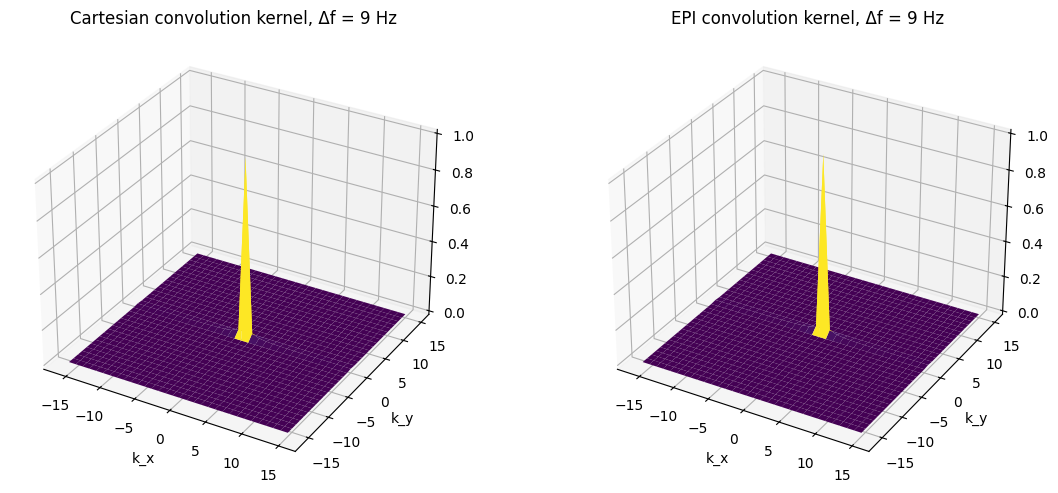

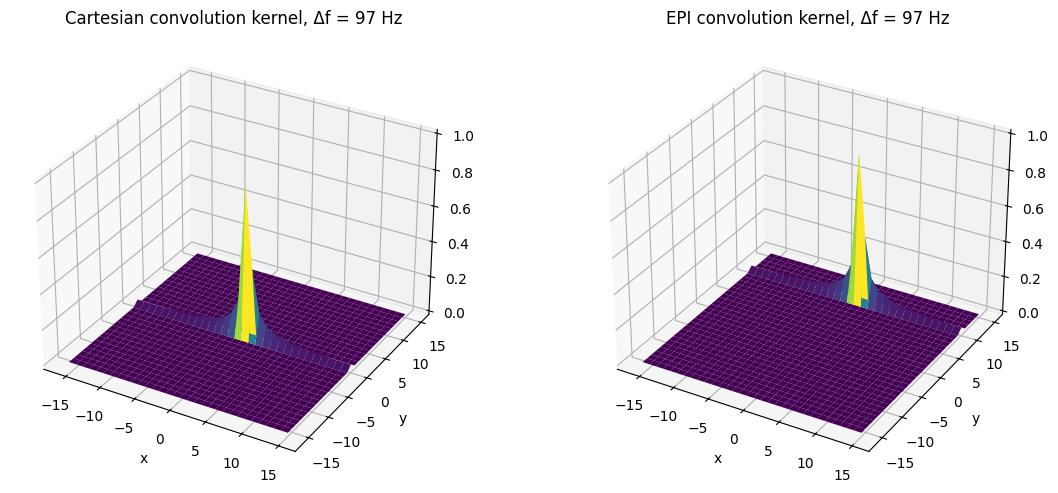

In [20]:
# Convolution kernels for off-resonance weighting

def ifft2c(x):
    # Centered 2D inverse FFT
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(x)))

df = 1 / (N * tesp)  # kHz

W_Cartesian = ifft2c(np.exp(-1j * 2 * np.pi * df * upsilon_Cartesian))
W_EPI = ifft2c(np.exp(-1j * 2 * np.pi * df * upsilon_EPI))

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(x, y, np.abs(W_Cartesian), cmap='viridis')
ax1.set_xlabel('k_x')
ax1.set_ylabel('k_y')
ax1.set_title(f'Cartesian convolution kernel, Δf = {int(df*1e3)} Hz')
ax1.set_zlim(0, 1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(x, y, np.abs(W_EPI), cmap='viridis')
ax2.set_xlabel('k_x')
ax2.set_ylabel('k_y')
ax2.set_title(f'EPI convolution kernel, Δf = {int(df*1e3)} Hz')
ax2.set_zlim(0, 1)

plt.tight_layout()
plt.show()

df = 10 / (N * tesp)  # kHz

W_Cartesian = ifft2c(np.exp(-1j * 2 * np.pi * df * upsilon_Cartesian))
W_EPI = ifft2c(np.exp(-1j * 2 * np.pi * df * upsilon_EPI))

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(x, y, np.abs(W_Cartesian), cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f'Cartesian convolution kernel, Δf = {int(df*1e3)} Hz')
ax1.set_zlim(0, 1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(x, y, np.abs(W_EPI), cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title(f'EPI convolution kernel, Δf = {int(df*1e3)} Hz')
ax2.set_zlim(0, 1)

plt.tight_layout()
plt.show()

For frequency shift, the main peak of the convolution kernels is shifted frfom the origin.  This will result in a shift in the reconstructed image.  The shift is much larger for EPI and is in the phase encoding instead of the frequency encoding direction.  (The residual side lobes are due to sinc interpolation effects, similar to Gibbs ringing.)